In [ ]:
!pip install -r requirements.txt

In [1]:
import gensim
import numpy as np
import nltk
import pandas as pd
import pyLDAvis.gensim
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from gensim.models import CoherenceModel
nltk.download('wordnet')
np.random.seed(2018)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ayushgarg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_parquet("./products.parquet.gz")

### Data Preprocessing

* Concatenate product name and description to include all information in one sentence
* Use gensim utils simple preprocessing to convert text to lowercase
* Remove stopwords from the text 
* Lemmatizing and stemming the final tokens

In [3]:
data['product_description'] = data['product_description'].fillna(value = "")

In [4]:
data["product_concat"] = data['product_name'] + data['product_description']

In [5]:
data

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,product_concat
0,0,0,w21z6tu,Cheese Tofu,,116,Cheese Tofu
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30,Naughty & Nice - SliceChocolate - Slice
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25,301. Pork Dumpling with Hot Chilli Vinaigrette...
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45,Mee KuahContain minced mutton meat
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24,Ham & Cheese Sandwich SetToasted to perfection...
...,...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,,22,Sriracha Chicken Whole Wheat Pita
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22,Dettol Liquid Hand wash Sensitive 250mlâ€¢ Det...
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22,Red Bean4 Pcs
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22,"Twister MealChoice of 1 Twister, 1 Hash Brown ..."


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633148 entries, 0 to 633147
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   product_id           633148 non-null  int64 
 1   vendor_id            633148 non-null  int64 
 2   vendor_geohash       633148 non-null  object
 3   product_name         633148 non-null  object
 4   product_description  633148 non-null  object
 5   order_count          633148 non-null  int64 
 6   product_concat       633148 non-null  object
dtypes: int64(3), object(4)
memory usage: 33.8+ MB


In [7]:
def lemmatize_stemming(text):
    porter = PorterStemmer()
    return porter.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [8]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [9]:
processed_docs = data['product_concat'].map(preprocess)

In [10]:
processed_docs

0                                             [chees, tofu]
1                       [naughti, nice, slicechocol, slice]
2            [pork, dumpl, chilli, vinaigrett, 红油抄手, spici]
3                         [kuahcontain, minc, mutton, meat]
4         [chees, sandwich, settoast, perfect, sandwich,...
                                ...                        
633143                     [sriracha, chicken, wheat, pita]
633144    [dettol, liquid, hand, wash, sensit, dettol, l...
633145                                               [bean]
633146    [twister, mealchoic, twister, hash, brown, cho...
633147                                  [chocol, croissant]
Name: product_concat, Length: 633148, dtype: object

In [11]:
pickle.dump(processed_docs, open( "processed_docs.p", "wb" ))

In [12]:
processed_docs = pickle.load(open("processed_docs.p", "rb"))

In [13]:
from wordcloud import WordCloud
all_word = []
for word in processed_docs:
    all_word.extend(word)
all_words = ''.join(all_word)

In [14]:
word_dict = dict(Counter(all_word))

In [15]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color="white").generate_from_frequencies(word_dict)

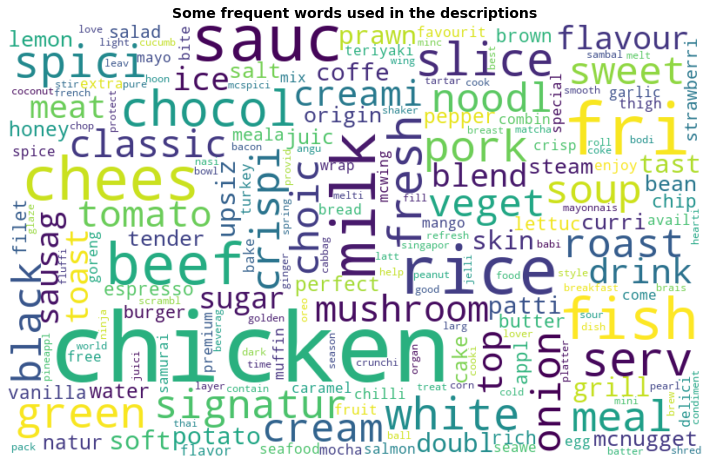

In [16]:
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the descriptions", weight='bold', fontsize=14)
plt.show()

### Modelisation
* Prepare dictionary of all the words in the text
* Filter out words from the dictionary that appear less than 15 times in the text and more than 50% of all texts
* Convert dictionary to bag of words
* Get tf-idf representation from bag of words
* Train LDA(Latent Dirichlet Allocation) model with 3 topics

In [17]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [18]:
len(dictionary)

63972

In [19]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=20000)

In [20]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [25]:
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [26]:
lda_model_3 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=3, workers=2)
for idx, topic in lda_model_3.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.018*"milk" + 0.015*"green" + 0.013*"goreng" + 0.010*"honey" + 0.010*"bean" + 0.008*"thai" + 0.008*"chip" + 0.008*"sweet" + 0.008*"roll" + 0.008*"lemon"
Topic: 1 
Words: 0.035*"chicken" + 0.030*"rice" + 0.027*"fri" + 0.016*"fish" + 0.014*"soup" + 0.014*"pork" + 0.013*"noodl" + 0.011*"beef" + 0.011*"chees" + 0.010*"sauc"
Topic: 2 
Words: 0.016*"chocol" + 0.011*"milk" + 0.010*"brown" + 0.009*"sugar" + 0.009*"sausag" + 0.008*"coffe" + 0.005*"chicken" + 0.005*"origin" + 0.005*"soft" + 0.005*"toast"


In [27]:
lda_display = pyLDAvis.gensim.prepare(lda_model_3, corpus_tfidf, dictionary, sort_topics=False)

In [28]:
pyLDAvis.display(lda_display)

### Model Inference on the original data

In [29]:
topics = []
scores = []

In [30]:
for scores_row in lda_model_3[corpus_tfidf]:
    sorted_row = sorted(scores_row, key=lambda tup: -1*tup[1])
    topics.append(sorted_row[0][0])
    scores.append(sorted_row[0][1])

In [31]:
processed_df = data.copy()
processed_df['topics'] = topics
processed_df['scores'] = scores

In [32]:
processed_df['topics'].value_counts()

1    270003
0    194804
2    168341
Name: topics, dtype: int64

In [33]:
processed_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,product_concat,topics,scores
0,0,0,w21z6tu,Cheese Tofu,,116,Cheese Tofu,1,0.713356
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30,Naughty & Nice - SliceChocolate - Slice,2,0.691177
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25,301. Pork Dumpling with Hot Chilli Vinaigrette...,1,0.589991
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45,Mee KuahContain minced mutton meat,1,0.524918
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24,Ham & Cheese Sandwich SetToasted to perfection...,1,0.475010
...,...,...,...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,,22,Sriracha Chicken Whole Wheat Pita,0,0.505476
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22,Dettol Liquid Hand wash Sensitive 250mlâ€¢ Det...,2,0.872379
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22,Red Bean4 Pcs,0,0.666659
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22,"Twister MealChoice of 1 Twister, 1 Hash Brown ...",0,0.550432


### Checking top products in each topic ordered by score

In [34]:
topic0 = processed_df.loc[processed_df['topics'] == 0].sort_values('scores', ascending = False)

In [35]:
topic1 = processed_df.loc[processed_df['topics'] == 1].sort_values('scores', ascending = False)

In [36]:
topic2 = processed_df.loc[processed_df['topics'] == 2].sort_values('scores', ascending = False)

In [37]:
topic0[:500]['product_name'].value_counts()

Double Samurai Beef Upsized Meal                           230
Pink Christmas                                              21
Sportade Strawberry Sports Drink Bottle 500ml               14
Remedy Kombucha Multipack Raspberry Lemonade 4s x 250ml     14
Mogu Mogu Strawberry Juice with Nata de Coco 1L             14
Remedy Kombucha Raspberry Lemonade Bottle 330ml             14
Remedy Kombucha Lemon Lime & Mint Bottle 330ml              14
Remedy Kombucha Multipack Peach 4s x 250ml                  14
Sportade Purple Grape Sports Drink Bottle 500ml             14
Sportade Ice Blueberry Sports Drink Bottle 500ml            14
Remedy Kombucha Peach Bottle 330ml                          14
Remedy Kombucha Apple Crisp Bottle 330ml                    13
Remedy Kombucha Multipack Apple Crisp 4s x 250ml            13
East Imperial Grapefruit Tonic 4s x 150ml                   12
Remedy Kombucha Original 330ml                              12
Remedy Kombucha Multipack Lemon Lime & Mint 4s x 250ml 

In [38]:
topic1[:5000]['product_name'].value_counts()

Filet-O-Fish® Upsized Meal                                                   816
Ninja Chicken Upsized Meal                                                   803
Buttermilk Crispy Chicken Upsized Meal                                       684
Ninja Chicken Meal                                                           606
Buttermilk Crispy Chicken Meal                                               520
Buttermilk Crispy Chicken                                                    310
Roasted Chicken Sub                                                          300
Ninja Chicken                                                                289
Roasted Chicken Wrap                                                         227
Roasted Chicken Flatbread                                                    165
Roasted Chicken Salad                                                        141
Combo Grill with Truffle Mushroom Soup                                        22
Yakiniku Bento              

In [39]:
topic2[:10000]['product_name'].value_counts()

Breakfast Wrap Sausage Meal                                               855
Breakfast Deluxe™ Meal                                                    847
Mudpie McFlurry®                                                          644
Breakfast Wrap Sausage                                                    337
Breakfast Deluxe™                                                         228
                                                                         ... 
Guardian 4Pc Manicure Set (165737)                                          1
JM Solution Glow Luminous Aurora Mask (616628) | 10 pieces                  1
Klairs Gentle Black Sugar Charcoal Soap | 100 g                             1
Assure Adult Value Diapers Large | 10x1 pack                                1
Medi-Gel Medi-Gel All Purpose Gel Pack - By Medic Drugstore | 1 pieces      1
Name: product_name, Length: 631, dtype: int64

### Inference
* Topic 0 mostly contains medicines and daily groceries
* Topic 1 mostly contains main course food items including local Singaporean foods
* Topic 2 mostly contains Macdonald's items and drinks

### Vendor Recommendations

- Group topics by Geohash and calculate % of each topic in the geohash. 
- For a given vendor, we can then make recommendations based on the popular topics in his geohash

In [40]:
grouped_processed = processed_df.groupby(['vendor_geohash', 'topics']).agg({'product_name': 'count'})
grouped_pcts = grouped_processed.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

In [41]:
grouped_pcts = grouped_pcts.reset_index()

In [42]:
grouped_pcts

,vendor_geohash,topics,product_name
0,ttsg7zf,1,100.000000
1,w21xjy4,1,100.000000
2,w21xpjq,0,51.162791
3,w21xpjq,1,27.906977
4,w21xpjq,2,20.930233
...,...,...,...
7161,w23bhd6,1,73.333333
7162,w23bhd6,2,20.000000
7163,w23bhdd,0,40.060469
7164,w23bhdd,1,14.764424


In [43]:
pivoted = grouped_pcts.pivot(index='vendor_geohash', columns='topics', values='product_name')

In [44]:
pivoted = pivoted.fillna(0.0)

In [45]:
pivoted.columns = ['T0: Daily Use Items' , 'T1: Main Course', 'T2: McDonalds and drinks']

In [46]:
pivoted

,T0: Daily Use Items,T1: Main Course,T2: McDonalds and drinks
vendor_geohash,,,
ttsg7zf,0.000000,100.000000,0.000000
w21xjy4,0.000000,100.000000,0.000000
w21xpjq,51.162791,27.906977,20.930233
w21xpr4,26.923077,34.615385,38.461538
w21xqws,100.000000,0.000000,0.000000
...,...,...,...
w23bh2w,15.686275,41.830065,42.483660
w23bh2y,18.000000,74.000000,8.000000
w23bh39,24.545455,57.272727,18.181818


In [47]:
processed_df = processed_df.merge(pivoted, on = 'vendor_geohash')

In [48]:
processed_df.sort_values('product_id')

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,product_concat,topics,scores,T0: Daily Use Items,T1: Main Course,T2: McDonalds and drinks
0,0,0,w21z6tu,Cheese Tofu,,116,Cheese Tofu,1,0.713356,29.591837,51.530612,18.877551
196,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30,Naughty & Nice - SliceChocolate - Slice,2,0.691177,34.905660,31.027254,34.067086
1150,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25,301. Pork Dumpling with Hot Chilli Vinaigrette...,1,0.589991,30.197769,48.935091,20.867140
5094,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45,Mee KuahContain minced mutton meat,1,0.524918,26.077098,63.718821,10.204082
5535,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24,Ham & Cheese Sandwich SetToasted to perfection...,1,0.475010,28.055556,39.277778,32.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
237887,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,,22,Sriracha Chicken Whole Wheat Pita,0,0.505476,39.716312,29.851709,30.431979
37249,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22,Dettol Liquid Hand wash Sensitive 250mlâ€¢ Det...,2,0.872379,38.633819,15.498320,45.867861
355940,633145,4135,w21ztw0,Red Bean,4 Pcs,22,Red Bean4 Pcs,0,0.666659,29.130010,30.987292,39.882698
448421,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22,"Twister MealChoice of 1 Twister, 1 Hash Brown ...",0,0.550432,39.675676,40.324324,20.000000


In [49]:
coherence_model_lda = CoherenceModel(model=lda_model_3, texts=processed_docs, dictionary=dictionary, coherence='c_v')

In [50]:
coherence_lda = coherence_model_lda.get_coherence()

In [51]:
coherence_lda

0.3201365479048332

### Selecting the appropriate number of topics

In [52]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=3, workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [53]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=processed_docs, start=2, limit=25, step=5)

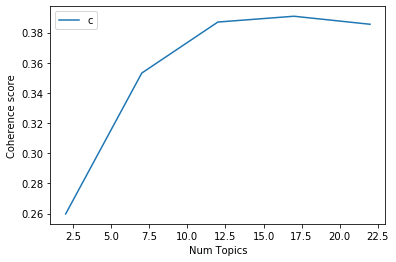

In [54]:
limit=25; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()